# Healthcare AI Agent

<img src="AIWorkflow.png" width="250" align="center"/>
<br>
<br>
<p>
Healthcare AI Agent that automates:
    <li>
        Accepts incoming patient datasets.
    </li>
    <li>
        Automates preprocessing.
    </li>
    <li>
        Automatically categorises risk into Low / Medium / High
    </li>	
</p>

## Importing libraries

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm


## Load Data

In [72]:
print("Loading dataset...")
data = pd.read_csv("Dataset_raw.csv")
data.dropna(inplace=True)
data['STROKE'] = data['STROKE'].apply(lambda x: 1 if x == 1 else 0)
selected_columns = ['TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CIGPDAY', 'BMI', 'STROKE']
data = data[selected_columns]


Loading dataset...


## Define Automated Preprocessing Functions

In [75]:
def categorise_cholesterol(value):
    if value < 200: return 'Normal'
    elif 200 <= value < 240: return 'Borderline High'
    return 'High'

def categorize_bp(value):
    if value < 120: return 'Normal'
    elif 120 <= value < 140: return 'Elevated'
    return 'Hypertension'

def categorise_diabp(value):
    if value <= 80: return 'Normal'
    elif 80 < value <= 90: return 'Elevated'
    return 'Hypertension'

def categorise_bmi(value):
    if value <= 24.9: return 'Normal Weight'
    elif 25 <= value <= 29.9: return 'Overweight'
    return 'Obese'


## Initial Preprocessing

In [78]:
for col, func in zip(['TOTCHOL', 'SYSBP', 'DIABP', 'BMI'],
                     [categorise_cholesterol, categorize_bp, categorise_diabp, categorise_bmi]):
    data[col] = data[col].apply(func)

categorical_columns = ['TOTCHOL', 'SYSBP', 'DIABP', 'BMI']
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])


##  Train-Test Split

In [81]:
X = data.drop(columns=['STROKE'])
y = data['STROKE']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


## Define the AI Agent

In [84]:
class StrokeRiskAgent:
    def __init__(self, model, encoders):
        self.model = model
        self.encoders = encoders

    def preprocess(self, df):
        df = df.copy()
        df['TOTCHOL'] = df['TOTCHOL'].apply(categorise_cholesterol)
        df['SYSBP'] = df['SYSBP'].apply(categorize_bp)
        df['DIABP'] = df['DIABP'].apply(categorise_diabp)
        df['BMI'] = df['BMI'].apply(categorise_bmi)
        for col in categorical_columns:
            df[col] = self.encoders[col].transform(df[col])
        return df

    def predict(self, df):
        print("\n[INFO] Processing new patient data...")
        df = self.preprocess(df)
        risk_scores = self.model.predict_proba(df)[:, 1]
        predictions = self.model.predict(df)
        risk_category = ["Low" if r < 0.3 else "Medium" if r < 0.7 else "High" for r in risk_scores]
        return pd.DataFrame({
            'Stroke Risk Score': risk_scores,
            'Risk Category': risk_category,
            'Prediction (0=No Stroke, 1=Stroke)': predictions
        })

    def export_results(self, predictions, filename="risk_report.csv"):
        predictions.to_csv(filename, index=False)
        print(f"\n[INFO] Risk report saved as {filename}")


## Training chosen ML Model: Gradient Boosting

<img src="GB_image.png" width="500" align="center"/>
<br>
<br>
<p>
The Gradient Boosting model works by sequentially reducing the errors of the previous models through iterations.
</p>
<br>
<p>
    Other models were tested for their accuracy and precision measures, including SVC, KNN etc These can be reviewed in the notebook called <b>Stroke Prediction<b>.
</p>

In [88]:
gb_model = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50, subsample=0.6, random_state=42
)
gb_model.fit(X_train, y_train)
agent = StrokeRiskAgent(gb_model, label_encoders)



[INFO] Evaluation on Test Set
AUC-ROC: 0.9327777777777777
Accuracy: 0.85
Precision: 0.8888888888888888
Recall: 0.8
F1-Score: 0.8421052631578947


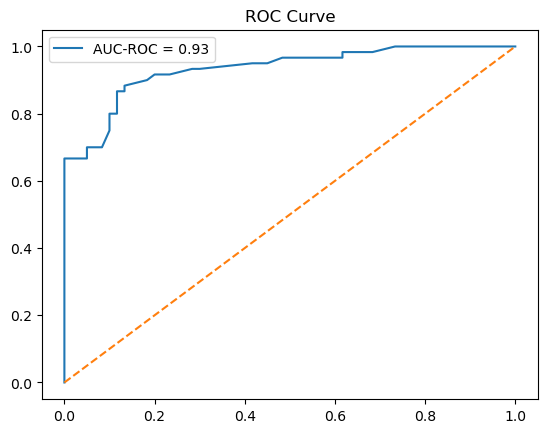

In [90]:
# new_patients = pd.read_csv("new_patients.csv")
# predictions = agent.predict(new_patients)
# agent.export_results(predictions)

y_pred = gb_model.predict(X_test)
y_proba = gb_model.predict_proba(X_test)[:, 1]

print("\n[INFO] Evaluation on Test Set")
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.show()